# Using Convpaint & Python - Introduction

Here, we show you the basics of using Convpaint programmatically with Python. Concretely, we will present 3 ways to use the Convpaint GUI and/or API:
-  **a)**    Using Convpaint **as a napari plugin (GUI)**, only accessing and processing the results programmatically afterwards
-  **b)**    **Training** a Convpaint model in the **GUI**, then using it **programmatically (API)** for **segmenting** new images
-  **c)**    Using the **Convpaint API** from end to end, without the GUI

When you intend to use Convpaint programmatically, it is important to understand the Convpaint API and its main concepts.

All the information you need can be found in the docs, notably the following resources:

- [Comprehensive Convpaint API tutorial](https://guiwitz.github.io/napari-convpaint/book/Convpaint_api_tutorial.html)
- [ConvpaintModel class reference](https://guiwitz.github.io/napari-convpaint/book/ConvpaintModel.html)
- [Description of Convpaint concepts](https://guiwitz.github.io/napari-convpaint/book/Description.html)
- [Convpaint parameters](https://guiwitz.github.io/napari-convpaint/book/Params_settings.html)
- [Description of the Feature Extractors](https://guiwitz.github.io/napari-convpaint/book/FE_descriptions.html)
- [Guide to annotations](https://guiwitz.github.io/napari-convpaint/book/Annotations.html)

## Imports

In [1]:
import napari
import matplotlib.pyplot as plt
import os
from napari_convpaint.conv_paint_model import ConvpaintModel
import numpy as np

## a) Use Convpaint entirely in Napari - only **access results via API**

Open a **napari viewer from within Python** to make its data accessible from there (this might take a while the first time, as napari will load all its plugins).

In [3]:
viewer = napari.Viewer()

In Napari:
- **Open** the Convpaint Plugin (this might take a while the first time, as Convpaint will load its models)
- **Use** Convpaint as usual to train a model and segment an image (e.g. with the "Cells 2D" sample image)
- **Access the results** as illustrated below

In [ ]:
seg = viewer.layers['segmentation'].data
img = viewer.layers['Cells 2D'].data

Display the results to verify it worked.

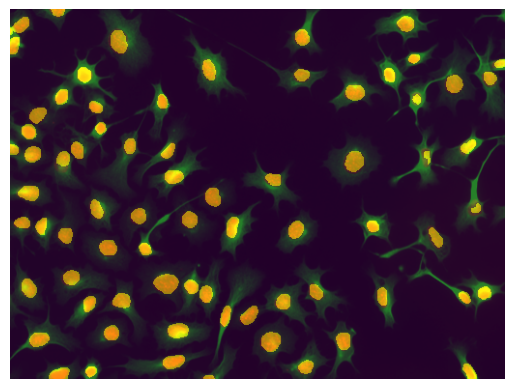

In [4]:
plt.imshow(img)
plt.imshow(seg, alpha=0.5)
plt.axis('off')
plt.show()

**From here, we could do post-processing and further analysis using packages like skimage, pandas and seaborn.**

**See the examples section for some inspiration.**

## b) **Train** a model **in the GUI**, then **use it programmatically (API)**

Repeat the steps above **until training** a model in the GUI, but then **save the model** as pickle file (in this example `BCSS_default_model.pkl`).

In [7]:
viewer2 = napari.Viewer()

Then, you can **load the model in Python**. To check what model we loaded, we can print its parameters.

In [8]:
cpm = ConvpaintModel(model_path="BCSS_default_model.pkl")

for p in cpm.get_params().items():
    print(p)

('classifier', 'CatBoost')
('channel_mode', 'rgb')
('normalize', 3)
('image_downsample', 1)
('seg_smoothening', 1)
('tile_annotations', True)
('tile_image', False)
('use_dask', False)
('unpatch_order', 1)
('fe_name', 'vgg16')
('fe_use_gpu', False)
('fe_layers', ['features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))'])
('fe_scalings', [1, 2, 4])
('fe_order', 0)
('fe_use_min_features', False)
('clf_iterations', 100)
('clf_learning_rate', 0.1)
('clf_depth', 5)
('clf_use_gpu', None)


And now we can use it **in Python on new images**.

Note that Convpaint **could also segment a batch of images** at once (see below), but since here we loop over them for loading anyway, we just segment them one by one.

<div class="alert alert-block alert-info">
<b>IMPORTANT</b>: Convpaint <b>expects your data to come as channel first</b>! This means that, for RGB images, typically, you need to move them from last to first dimension, e.g. `img = np.moveaxis(img, -1, 0)`.

Note that this happens automatically when using Convpaint in Napari, but needs to be done manually when using the API.
</div>


In [29]:
image_folder = "BCSS_examples/BCSS_windows"

imgs = []
segs = []
for i, file in enumerate(os.listdir(image_folder)):
    if not file.endswith(".png"):
        continue
    img = plt.imread(image_folder + "/" + file)
    print(f"Processing image {i+1}: {img.shape}")
    img = np.moveaxis(img, -1, 0)  # move channel last to channel first
    print(f"Reshaped image:     {img.shape}")

    seg = cpm.segment(img) # HERE WE SEGMENT THE IMAGES

    imgs.append(img)
    segs.append(seg)

Processing image 1: (1326, 1297, 3)
Reshaped image:     (3, 1326, 1297)
Processing image 2: (1326, 1297, 3)
Reshaped image:     (3, 1326, 1297)
Processing image 3: (1326, 1297, 3)
Reshaped image:     (3, 1326, 1297)
Processing image 4: (1326, 1297, 3)
Reshaped image:     (3, 1326, 1297)


And we can **display the results.**

<div class="alert alert-block alert-info">
<b>NOTE</b>: In pyplot, the images are shown in (H, W, C) format, so if we have reshaped the images to (C, H, W) format above, we need to <b>move the axes back for visualization purposes</b>.
</div>


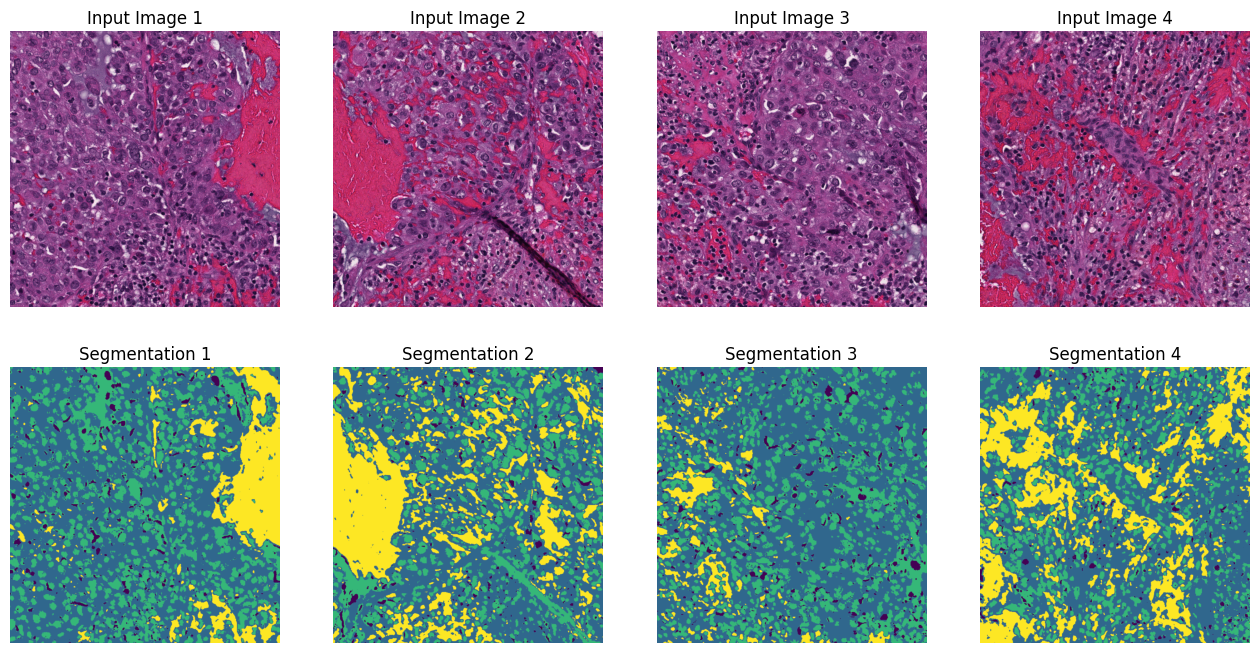

In [10]:
assert len(imgs) == len(segs) # sanity check that we have the same number of images and segmentations

fig, axs = plt.subplots(2, len(imgs), figsize=(4*len(imgs), 8))
for i, img in enumerate(imgs):
    axs[0, i].imshow(np.moveaxis(img, 0, -1)) # move channel first back to channel last for visualization
    axs[0, i].set_title(f"Input Image {i+1}")
    axs[1, i].imshow(segs[i])
    axs[1, i].set_title(f"Segmentation {i+1}")
    for ax in axs[:, i]:
        ax.axis('off')
plt.show()

## c) Use Convpaint **entirely in Python**

### 1. Create and set up model

Create a `ConvpaintModel` instance. See the [separate page](https://guiwitz.github.io/napari-convpaint/book/ConvpaintModel.html) for more options for initialization.

In [11]:
cpm2 = ConvpaintModel() # create a default model (without a trained classifier)

Change **parameters**, just like in the GUI. Again, refer to the [separate page](https://guiwitz.github.io/napari-convpaint/book/Params_settings.html) describing all parameters.

In [12]:
# First get an overview of the available parameters and their default values
for p in cpm2.get_params().items():
    print(p)

('classifier', None)
('channel_mode', 'single')
('normalize', 2)
('image_downsample', 1)
('seg_smoothening', 1)
('tile_annotations', True)
('tile_image', False)
('use_dask', False)
('unpatch_order', 1)
('fe_name', 'vgg16')
('fe_use_gpu', False)
('fe_layers', ['features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))'])
('fe_scalings', [1, 2, 4])
('fe_order', 0)
('fe_use_min_features', False)
('clf_iterations', 100)
('clf_learning_rate', 0.1)
('clf_depth', 5)
('clf_use_gpu', None)


In [13]:
# Now set some parameters to non-default values
cpm2.set_params(channel_mode="multi", normalize=3, seg_smoothening=2)

### 2. Train the model

Now, we first need to **train the model**. 

For this, we need **images and corresponding annotations**. Remember to move the channels to the first dimension if needed.

**NOTE**: To read annotations, we here use `skimage.io.imread` instead of `plt.imread`, as the latter will rescale the values to [0, 1], which we do not want for annotations. You could also manually rescale the values back to integers, but using `skimage.io.imread` is easier.

In [14]:
image_folder = "cellpose_examples"

img0 = plt.imread(image_folder + "/" + "000_img.png")

import skimage
annot0 = skimage.io.imread(image_folder + "/" + "000_scribbles_all_01000_w1_run07_annot.png")

print(f"Image shape: {img0.shape}, Annotation shape: {annot0.shape}")
img0 = np.moveaxis(img0, -1, 0)  # move channel last to channel first
print(f"Reshaped image: {img0.shape}")

Image shape: (383, 512, 3), Annotation shape: (383, 512)
Reshaped image: (3, 383, 512)


In [21]:
print(np.unique(annot0)) # check unique labels in the annotations
print(f"Num annotated pixels: 1 = {(annot0 == 1).sum()}, 2 = {(annot0 == 2).sum()}") # check number of pixels per label

[0 1 2]
Num annotated pixels: 1 = 983, 2 = 940


In [ ]:
clf = cpm2.train(img0, annot0) # HERE WE TRAIN THE MODEL

### 3. Segment new images

FE model is designed for imagenet normalization, but image is not declared as 'rgb' (parameter channel_mode). Using default normalization instead.


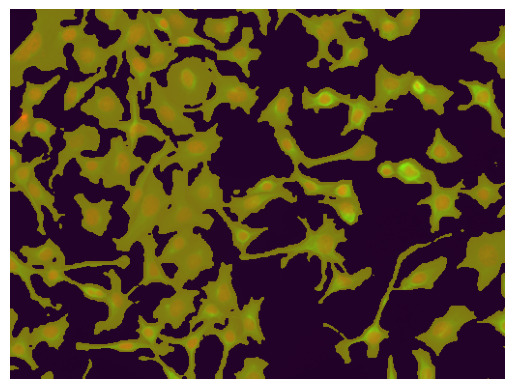

In [23]:
img1 = plt.imread(image_folder + "/" + "001_img.png")
img1 = np.moveaxis(img1, -1, 0)  # move channel last to channel first


seg = cpm2.segment(img1)

plt.imshow(np.moveaxis(img1, 0, -1)) # move channel first back to channel last for visualization
plt.imshow(seg, alpha=0.5)
plt.axis('off')
plt.show()

### Optional: **Train on multiple** images

We can also train on multiple images and annotations at once by passing lists of arrays.

In [24]:
img_names =["000_img.png", "001_img.png"]
annot_names =["000_scribbles_all_01000_w1_run07_annot.png", "001_scribbles_all_01000_w1_run07_annot.png"]

imgs = [plt.imread(image_folder + "/" + name) for name in img_names]
imgs = [np.moveaxis(img, -1, 0) for img in imgs]  # move channel last to channel first

annots = [skimage.io.imread(image_folder + "/" + name) for name in annot_names]

In [25]:
cpm3 = ConvpaintModel(fe_name="vgg16", channel_mode="multi", normalize=3, seg_smoothening=2)

In [26]:
clf = cpm3.train(imgs, annots) # HERE WE TRAIN ON MULTIPLE IMAGES

FE model is designed for imagenet normalization, but image is not declared as 'rgb' (parameter channel_mode). Using default normalization instead.
FE model is designed for imagenet normalization, but image is not declared as 'rgb' (parameter channel_mode). Using default normalization instead.
0:	learn: 0.5355210	total: 11ms	remaining: 1.09s
1:	learn: 0.4268868	total: 22.5ms	remaining: 1.1s
2:	learn: 0.3455982	total: 31.7ms	remaining: 1.02s
3:	learn: 0.2939234	total: 40.7ms	remaining: 977ms
4:	learn: 0.2505869	total: 49.5ms	remaining: 941ms
5:	learn: 0.2164440	total: 58.2ms	remaining: 913ms
6:	learn: 0.1882357	total: 68.1ms	remaining: 905ms
7:	learn: 0.1697273	total: 76.2ms	remaining: 876ms
8:	learn: 0.1547895	total: 85.3ms	remaining: 863ms
9:	learn: 0.1432902	total: 93.8ms	remaining: 844ms
10:	learn: 0.1303033	total: 103ms	remaining: 833ms
11:	learn: 0.1214221	total: 112ms	remaining: 819ms
12:	learn: 0.1140107	total: 120ms	remaining: 805ms
13:	learn: 0.1076304	total: 129ms	remaining: 7

### Optional: Predict **probabilities**, and **predict multiple** files

And we can **segment - or predict separate class probability maps** - on a **list of images** as well.

In [27]:
probas = cpm3.predict_probas(imgs) # HERE WE PREDICT PROBABILITIES

num_imgs = len(probas)
num_classes = probas[0].shape[0]

print(f"Number of images: {num_imgs} | Number of classes: {num_classes}")

FE model is designed for imagenet normalization, but image is not declared as 'rgb' (parameter channel_mode). Using default normalization instead.
FE model is designed for imagenet normalization, but image is not declared as 'rgb' (parameter channel_mode). Using default normalization instead.
Number of images: 2 | Number of classes: 2


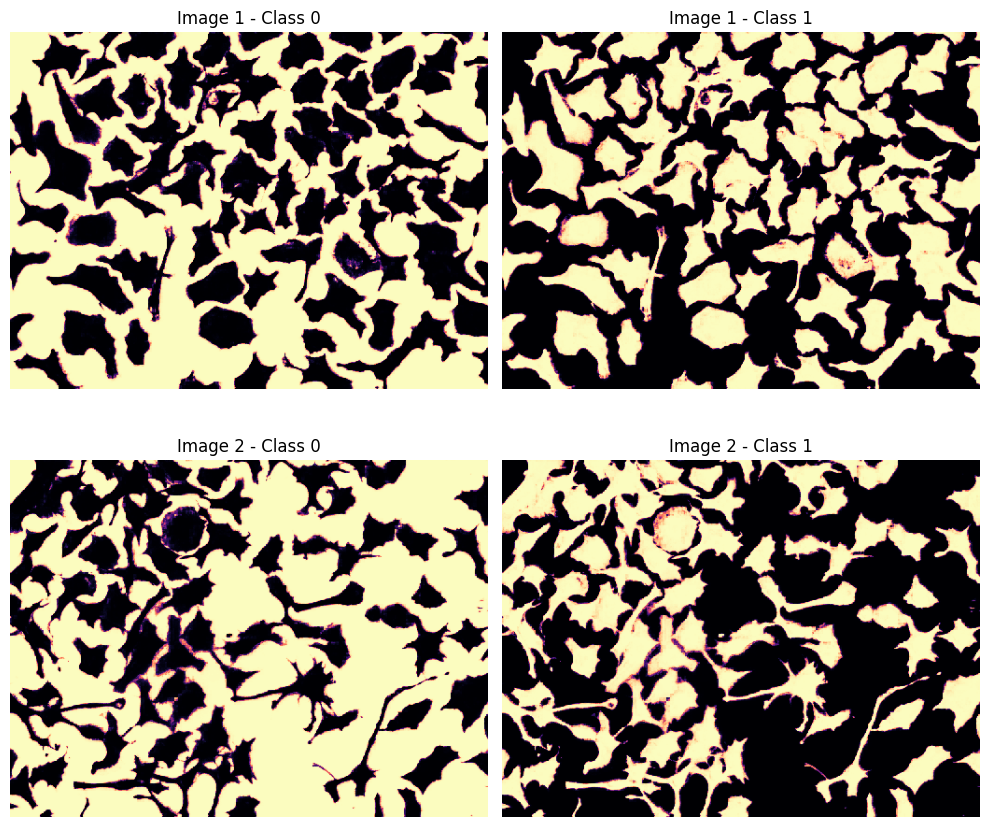

In [28]:
fig, ax = plt.subplots(nrows=num_imgs, ncols=num_classes, figsize=(10, 9))

for i, proba_im in enumerate(probas):
    for cl in range(num_classes):
        ax[i, cl].imshow(proba_im[cl], cmap='magma')
        ax[i, cl].set_title(f"Image {i+1} - Class {cl}")
        ax[i, cl].axis('off')
plt.tight_layout()
plt.show()